In [1]:
##Ridge regression 

import os
import matplotlib.pyplot as plt
import numpy as np
import scripts.implementations as lib  # Add personal library
import scripts.proj1_helpers as helper  # Add personal library

%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4)

DATA_FOLDER = 'data'
DATA_TRAIN = os.path.join(DATA_FOLDER, 'train.csv')
DATA_TEST = os.path.join(DATA_FOLDER, 'test.csv')

y, x, ids, header = helper.load_csv_data(DATA_TRAIN)
y_train, x_train,  y_validation, x_validation = lib.sep_valid_train_data(x,y, 0.8);
print(y_train.shape)

(200000,)


In [2]:
x_train[x_train == -999] = np.nan
x_validation[x_validation == -999] = np.nan

In [3]:
for i, feature in enumerate(x_train.T):
    print('Feature {} - {} has range: [{:.4f}, {:.4f}]'.format(
        i+1, header[i], np.nanmin(feature), np.nanmax(feature)))

Feature 1 - DER_mass_MMC has range: [9.0440, 1192.0260]
Feature 2 - DER_mass_transverse_met_lep has range: [0.0000, 595.8190]
Feature 3 - DER_mass_vis has range: [6.4620, 1329.9130]
Feature 4 - DER_pt_h has range: [0.0000, 1053.8070]
Feature 5 - DER_deltaeta_jet_jet has range: [0.0000, 8.5030]
Feature 6 - DER_mass_jet_jet has range: [13.6020, 4974.9790]
Feature 7 - DER_prodeta_jet_jet has range: [-18.0660, 16.6900]
Feature 8 - DER_deltar_tau_lep has range: [0.2080, 5.6840]
Feature 9 - DER_pt_tot has range: [0.0000, 513.6590]
Feature 10 - DER_sum_pt has range: [46.1040, 1852.4620]
Feature 11 - DER_pt_ratio_lep_tau has range: [0.0470, 19.7730]
Feature 12 - DER_met_phi_centrality has range: [-1.4140, 1.4140]
Feature 13 - DER_lep_eta_centrality has range: [0.0000, 1.0000]
Feature 14 - PRI_tau_pt has range: [20.0000, 622.8620]
Feature 15 - PRI_tau_eta has range: [-2.4990, 2.4970]
Feature 16 - PRI_tau_phi has range: [-3.1420, 3.1420]
Feature 17 - PRI_lep_pt has range: [26.0000, 461.8960]
Fea

In [ ]:
plt.figure(figsize=(16,60))

for i, feature in enumerate(x_train.T):
    plt.subplot(15, 2, i+1)
    id_keep = ~np.isnan(feature)
    id_b = np.logical_and(y_train == -1, id_keep)
    id_s = np.logical_and(y_train == 1, id_keep)
    plt.hist(feature[id_keep], bins=100, alpha=0.4, label='total')
    plt.hist(feature[id_b], alpha=0.4, bins=100, label='back')
    plt.hist(feature[id_s], alpha=0.4, bins=100, label='signal')
    plt.title('Feature {} - {}'.format(i+1, header[i]))
    plt.legend()
plt.tight_layout()

In [ ]:
plt.figure(figsize=(16,24))

for i, feature in enumerate(x_train.T):
    plt.subplot(10, 3, i+1)
    id_keep = ~np.isnan(feature)
    id_b = np.logical_and(y_train == -1, id_keep)
    id_s = np.logical_and(y_train == 1, id_keep)
    plt.boxplot([feature[id_keep], feature[id_b], feature[id_s]], whis=2.5, 
                vert=False, labels=['total', 'back', 'signal'])
    plt.title('Feature {} - {}'.format(i+1, header[i]))

plt.tight_layout()

In [ ]:
from scripts.ml import augmented_feat_angle

id_angle_feat = np.array([15, 18, 20, 25, 28])
id_left = [ i for i in range(x_train.shape[1]) if i not in id_angle_feat]

# Augment features
x_aug = augmented_feat_angle(x_train, id_angle_feat)
x_aug[:, 0] = recenter_feature(x_aug[:, 0])
x_aug[:, 1] = recenter_feature(x_aug[:, 1])
x_aug[:, 2] = recenter_feature(x_aug[:, 2])
x_aug[:, 3] = recenter_feature(x_aug[:, 3])
x_aug[:, 4] = recenter_feature(x_aug[:, 4])
x_aug[:, 5] = recenter_feature(x_aug[:, 5])
x_aug[:, 6] = recenter_feature(x_aug[:, 6])
x_aug[:, 7] = recenter_feature(x_aug[:, 7])
x_aug[:, 8] = recenter_feature(x_aug[:, 8])
x_aug[:, 9] = recenter_feature(x_aug[:, 9])

In [ ]:
plt.figure(figsize=(16,20))

for i, feature in enumerate(x_aug.T):
    plt.subplot(5, 2, i+1)
    id_keep = ~np.isnan(feature)
    id_b = np.logical_and(y_train == -1, id_keep)
    id_s = np.logical_and(y_train == 1, id_keep)
    plt.hist(feature[id_keep], bins=100, alpha=0.4, label='total')
    plt.hist(feature[id_b], alpha=0.4, bins=100, label='back')
    plt.hist(feature[id_s], alpha=0.4, bins=100, label='signal')
    plt.title('Feature {} - {}'.format(int(i/2)+1, header[id_angle_feat[int(i/2)]]))
    plt.legend()
plt.tight_layout()

In [ ]:
plt.figure(figsize=(16,16))

for i, feature in enumerate(x_aug.T):
    plt.subplot(5, 2, i+1)
    id_keep = ~np.isnan(feature)
    id_b = np.logical_and(y_train == -1, id_keep)
    id_s = np.logical_and(y_train == 1, id_keep)
    plt.boxplot([feature[id_keep], feature[id_b], feature[id_s]], whis=2.5, 
                vert=False, labels=['total', 'back', 'signal'])
    plt.title('Feature {} - {}'.format(int(i/2)+1, header[id_angle_feat[int(i/2)]]))

plt.tight_layout()

In [4]:
def plot_train_test(train_errors, test_errors, lambdas, degree):
    """
    train_errors, test_errors and lambas should be list (of the same size) the respective train error and test error for a given lambda,
    * lambda[0] = 1
    * train_errors[0] = RMSE of a ridge regression on the train set
    * test_errors[0] = RMSE of the parameter found by ridge regression applied on the test set
    
    degree is just used for the title of the plot.
    """
    plt.semilogx(lambdas, train_errors, color='b', marker='*', label="Train error")
    plt.semilogx(lambdas, test_errors, color='r', marker='*', label="Test error")
    plt.xlabel("lambda")
    plt.ylabel("RMSE")
    plt.title("Ridge regression for polynomial degree " + str(degree))
    leg = plt.legend(loc=1, shadow=True)
    leg.draw_frame(False)
    plt.savefig("ridge_regression")
    
def test_ridge_regression(x, y, x_val, y_val, degrees, lambdas):
    
    best_acc = 0
    best_degree = 0
    best_lambda = 0
    best_rmse_tr = []
    best_rmse_te = []
    best_weights = []
    for degree in degrees:
        degree = int(degree)
        #lambdas = np.logspace(-7, 2, 20)

        # Split sets
        #x_train, x_test, y_train, y_test = split_data(x, y, ratio, seed)

        # Get ploynomial
        phi_train = lib.build_poly(x, degree)
        phi_test = lib.build_poly(x_val, degree)

        rmse_tr = []
        rmse_te = []
        update_rmse = False

        for ind, lambda_ in enumerate(lambdas):

            mse_tr, weights = lib.ridge_regression(y, phi_train, lambda_)
            mse_te = lib.compute_loss(y_val, phi_test.dot(weights))
            rmse_tr.append(np.sqrt(2*mse_tr))
            rmse_te.append(np.sqrt(2*mse_te))

            print("degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                    d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
            print('train acc : ', lib.accuracy(y, phi_train.dot(weights)))
            val_acc = lib.accuracy(y_val, phi_test.dot(weights))
            print('validation acc : ', val_acc)

            if(val_acc > best_acc):
                best_acc = val_acc
                best_degree = degree
                best_lambda = lambda_
                best_weights = weights
                update_rmse = True
        
        if(update_rmse):
            best_rmse_tr = rmse_tr
            best_rmse_te = rmse_te

        # Plot the best obtained results
    plot_train_test(best_rmse_tr, best_rmse_te, lambdas, best_degree)

    print('Best params for Ridge regression : degree = ',best_degree, ', lambda = ',best_lambda,', accuracy = ', best_acc)
    
    return best_weights, best_degree, best_lambda

## Ridge with no_nan


In [45]:
#distrib = [ 'p', 'i', 'p', 'p', 'i', 'p', 'g', 'g', 'p', 'p',
#            'p', 'u', 'u', 'i', 'g', 'f', 'i', 'g', 'f', 'p',
#            'f', 'p', 'd', 'i', 'g', 'f', 'i', 'g', 'f', 'p']

distrib = ['g']*30

def norm_poisson(feature, perc_threshold=0.01):
    length = feature.shape[0];
    idx_val = np.int(np.ceil(length*perc_threshold))
    idx_outliers = np.argsort(feature)[-idx_val:]
    maxval = feature[np.argsort(feature)[ -(idx_val+1) ]]
    feature[idx_outliers] = maxval
    mean = np.nanmean(feature)
    std = np.nanstd(feature)
    feature -= mean
    feature /= std
    return feature, mean, std, maxval

def norm_poisson_feed(feature, mean_ref, std_ref, maxval):    
    feature[feature > maxval] = maxval
    feature -= mean_ref
    feature /= std_ref
    return feature

def norm_gaussian(feature, n_std=2.5):
    
    feat_cent = feature-np.nanmean(feature)
    std_thresh = np.nanstd(feat_cent, axis=0)
    maxval = n_std*std_thresh
    
    mean_update = np.nanmean(feature[np.abs(feat_cent) < maxval])
    std_update = np.nanstd(feature[np.abs(feat_cent) < maxval])
    feat_final = feature-mean_update
    feat_final[feat_final > maxval] = maxval
    feat_final[feat_final < -maxval] = -maxval
    feat_final /= std_update
    
    #feature[feature > maxval] = maxval
    #feature[feature < -maxval] = -maxval
    
    #mean_update = np.nanmean(feature)
    #std_update = np.nanstd(feature)
    #feature = (feature-mean_update)/std_update
        
    #return feature, mean_update, std_update, maxval

    return feat_final, mean_update, std_update, maxval

def norm_gaussian_feed(feature, mean_ref, std_ref, maxval):    
    feat_final = feature - mean_ref
    feat_final[feat_final > maxval]  = maxval
    feat_final[feat_final < -maxval] = -maxval
    feat_final /= std_ref
    return feat_final

def normalize_outliers(x_in, dist_type):
    # 1. Substract mean
    # 2. Compute std and detect ouliers
    # 3. Compute std and mean witout ouliers
    mean_corr = []
    std_corr = []
    max_val_corr = []
                
    for i, feat in enumerate(x_in.T):
        # Normalize according to distribution
        if dist_type[i] == 'g' or dist_type[i] == 'i' or dist_type[i] == 'u' \
                or dist_type[i] == 'f' or dist_type[i] == 'd':
            feat_new, mean_new, std_new, max_val_new = norm_gaussian(feat)
        elif dist_type[i] == 'p':
            feat_new, mean_new, std_new, max_val_new = norm_poisson(feat)
        else:
            feat_new, mean_new, std_new, max_val_new = (feat, 0, 1, np.inf)
        # Affect new values
        mean_corr.append(mean_new)
        std_corr.append(std_new)
        max_val_corr.append(max_val_new)
        x_in[:, i] = feat_new
    return x_in, mean_corr, std_corr, max_val_corr

def normalize_outliers_feed(x_in, mean_ref, std_ref, max_ref, dist_type):
    # 1. Substract mean
    # 2. Compute std and detect ouliers
    # 3. Compute std and mean witout ouliers
    
    for i, feat in enumerate(x_in.T):
        # Normalize according to distribution
        if dist_type[i] == 'g' or dist_type[i] == 'i' or dist_type[i] == 'u' \
                or dist_type[i] == 'f' or dist_type[i] == 'd':
            feat_new = norm_gaussian_feed(feat, mean_ref[i], std_ref[i], max_ref[i])
        elif dist_type[i] == 'p':
            feat_new = norm_poisson_feed(feat, mean_ref[i], std_ref[i], max_ref[i])
        else:
            feat_new = feat
        # Affect new value
        x_in[:, i] = feat_new
    return x_in

### UNUSED 
def remove_useless(x_in, id_useless=[15, 18, 20, 25, 28]):
    id_left = [ i for i in range(x_train.shape[1]) if i not in id_angle_feat]
    return x_in[:, id_left]

def recenter_feature(feature):
    val_max = np.nanmax(feature)
    val_min = np.nanmin(feature)
    feature[feature < np.nanmean(feature)] += (val_max - val_min)
    return feature
### UNUSED 

# normalize features
#x_no_nan = x_train.copy()
#x_no_nan = (x_no_nan - np.nanmean(x_no_nan, axis=0))/np.nanstd(x_no_nan, axis=0)
#x_no_nan = np.nan_to_num(x_no_nan)
#print('\nStd:', np.std(x_no_nan, axis=0))

# normalize features
#x_no_nan_val = x_validation.copy()
#x_no_nan_val = (x_no_nan_val - np.nanmean(x_no_nan_val, axis=0))/np.nanstd(x_no_nan_val, axis=0)
#x_no_nan_val = np.nan_to_num(x_no_nan_val)
#print('\nStd:', np.std(x_no_nan_val, axis=0))


# normalize features
#x_no_nan = x_train.copy()
#x_no_nan = (x_no_nan - np.nanmedian(x_no_nan, axis=0))/mad(x_no_nan)
#x_no_nan = np.nan_to_num(x_no_nan)
#print('\nStd:', mad(x_no_nan))

# normalize features
#x_no_nan_val = x_validation.copy()
#x_no_nan_val = (x_no_nan_val - np.nanmedian(x_no_nan_val, axis=0))/mad(x_no_nan_val)
#x_no_nan_val = np.nan_to_num(x_no_nan_val)
#print('\nStd:', mad(x_no_nan_val))

In [46]:
x_no_nan = x_train.copy()
x_no_nan, mean_train, std_train, max_train = normalize_outliers(x_no_nan, distrib)
#x_no_nan = remove_useless(x_no_nan)
x_no_nan = np.nan_to_num(x_no_nan)
print('\nStd:', np.std(x_no_nan, axis=0))

# normalize features
x_no_nan_val = x_validation.copy()
x_no_nan_val = normalize_outliers_feed(x_no_nan_val, mean_train, std_train, max_train, distrib)
#x_no_nan_val = remove_useless(x_no_nan_val)
x_no_nan_val = np.nan_to_num(x_no_nan_val)
print('\nStd:', np.std(x_no_nan_val, axis=0))

/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in less
/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in less
/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in greater
/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in less



Std: [ 1.074   1.0408  1.1532  1.1364  0.5519  0.6304  0.5907  1.0192  1.1146
  1.1341  1.1064  1.      0.5399  1.1454  1.      1.      1.1456  1.      1.
  1.1392  1.      1.1057  1.      0.89    0.7758  0.7753  0.6201  0.5399
  0.5399  1.1287]

Std: [ 1.0809  1.0384  1.1548  1.134   0.5455  0.6189  0.5829  1.0176  1.106
  1.1246  1.1044  1.0038  0.5337  1.1372  1.0017  1.0002  1.1371  1.0049
  1.0041  1.1418  0.9975  1.103   0.9936  0.8915  0.7739  0.7704  0.6114
  0.5313  0.5326  1.1198]


/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in greater
/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in less


degree=8, lambda=0.000, Training RMSE=0.730, Testing RMSE=0.729
train acc :  0.82182
validation acc :  0.8222
degree=8, lambda=0.000, Training RMSE=0.729, Testing RMSE=0.729
train acc :  0.822095
validation acc :  0.82248
degree=8, lambda=0.000, Training RMSE=0.729, Testing RMSE=0.729
train acc :  0.822055
validation acc :  0.8222
degree=8, lambda=0.000, Training RMSE=0.729, Testing RMSE=0.729
train acc :  0.82208
validation acc :  0.82224
degree=8, lambda=0.000, Training RMSE=0.729, Testing RMSE=0.729
train acc :  0.822095
validation acc :  0.82222
degree=8, lambda=0.000, Training RMSE=0.729, Testing RMSE=0.729
train acc :  0.822075
validation acc :  0.82222
degree=8, lambda=0.000, Training RMSE=0.729, Testing RMSE=0.729
train acc :  0.82204
validation acc :  0.82224
degree=8, lambda=0.000, Training RMSE=0.729, Testing RMSE=0.729
train acc :  0.821995
validation acc :  0.8223
degree=8, lambda=0.000, Training RMSE=0.729, Testing RMSE=0.729
train acc :  0.822
validation acc :  0.82218
d

degree=11, lambda=0.001, Training RMSE=0.779, Testing RMSE=0.777
train acc :  0.787795
validation acc :  0.7905
degree=11, lambda=0.003, Training RMSE=0.811, Testing RMSE=0.808
train acc :  0.764605
validation acc :  0.76796
degree=11, lambda=0.008, Training RMSE=0.845, Testing RMSE=0.842
train acc :  0.748565
validation acc :  0.75204
degree=11, lambda=0.018, Training RMSE=0.870, Testing RMSE=0.868
train acc :  0.73923
validation acc :  0.74284
degree=11, lambda=0.043, Training RMSE=0.890, Testing RMSE=0.887
train acc :  0.731145
validation acc :  0.73434
degree=11, lambda=0.100, Training RMSE=0.909, Testing RMSE=0.906
train acc :  0.721985
validation acc :  0.72576
Best params for Ridge regression : degree =  10 , lambda =  6.95192796178e-07 , accuracy =  0.82306


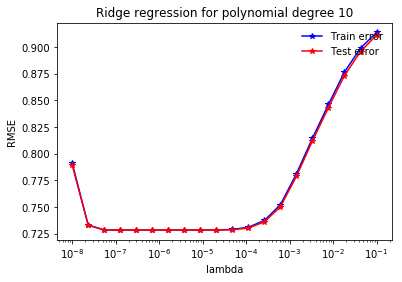

In [47]:
weights_no_nan, degree_no_nan, lambda_no_nan = test_ridge_regression(
    x_no_nan, y_train, x_no_nan_val, y_validation, degrees = np.linspace(8,11,4), lambdas=np.logspace(-8,-1, 20))

## Submission


In [ ]:
y_test, x_test, ids_test, header = helper.load_csv_data(DATA_TEST)
x_test[x_test == -999] = np.nan

x_no_nan_test = x_test.copy()
x_no_nan_test = normalize_outliers_feed(x_no_nan_test, mean_train, std_train)
x_no_nan_test = remove_useless(x_no_nan_test)
# x_no_nan_test = (x_no_nan_test - np.nanmedian(x_no_nan_test, axis=0))/mad(x_no_nan_test)
x_no_nan_test = np.nan_to_num(x_no_nan_test)
print('\nStd:', np.std(x_no_nan_test, axis=0))

In [ ]:
degree_opt = degree_no_nan
weights_opt = weights_no_nan

_phi_test = lib.build_poly(x_no_nan_test, degree_opt)
y_pred = helper.predict_labels(weights_opt, _phi_test)

In [ ]:
helper.create_csv_submission(ids_test, y_pred, 'ridge_no_nan1.csv')
print('Results saved ...')

In [ ]:
weights_no_nan